In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, widgets
import numpy as np

Using TensorFlow backend.


In [2]:
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print("Data shapes:")
print('images',images_train.shape)
print('labels', labels_train.shape)

Data shapes:
images (60000, 28, 28)
labels (60000,)


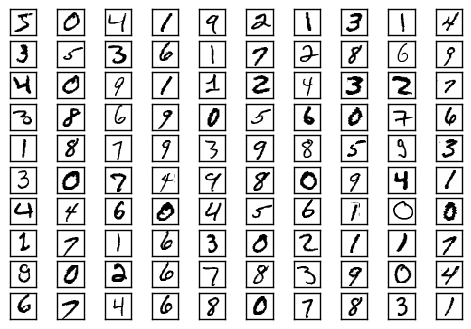

In [4]:
def plot_10_by_10_images(images, figsize=None): 
    fig = plt.figure()
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            ax.matshow(images[10*y+x], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    
plot_10_by_10_images(images_train, figsize=(10,10))

In [6]:
def to_features(X):
    return X.reshape(-1, 784).astype("float32") / 255.0

def to_images(X):
    return (X*255.0).astype('uint8').reshape(-1, 28, 28)

X_train = to_features(images_train)
X_test = to_features(images_test)  

y_train = np_utils.to_categorical(labels_train, num_classes=10)
y_test = np_utils.to_categorical(labels_test, num_classes=10)


In [9]:
nb_input = 784
nb_hidden = 128
batch_size = 128

ae = Sequential()
# encoder
ae.add(Dense(nb_hidden, input_dim=nb_input, init='uniform'))
ae.add(Activation('relu'))
# decoder
ae.add(Dense(nb_input, input_dim=nb_hidden, init='uniform'))
ae.add(Activation('relu'))

ae.compile(loss='mse', optimizer='SGD')



/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="uniform", input_dim=784)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(784, kernel_initializer="uniform", input_dim=128)`


In [10]:
nb_epoch = 3
ae.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

/Applications/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
60000/60000 [==============================] - 4s - loss: 0.1047     
Epoch 2/3
60000/60000 [==============================] - 4s - loss: 0.1013     
Epoch 3/3
60000/60000 [==============================] - 4s - loss: 0.0967     


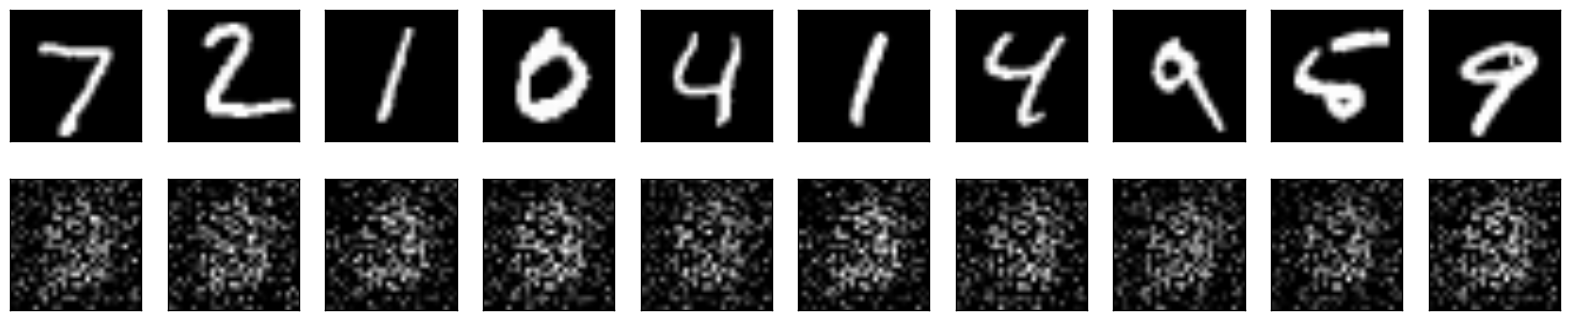

In [11]:
total = 10
decoded_imgs = []
for i in range(total):
    decoded_imgs.append(ae.predict(X_test[i].reshape(1,-1)))
    
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
class StackedAutoencoder(object):
    
    def __init__(self, layers, mode='autoencoder',
                 activation='relu', init='uniform', final_activation='softmax',
                 dropout=0.2, optimizer='SGD', metrics=["accuracy"]):
        self.layers = layers
        self.mode = mode
        self.activation = activation
        self.final_activation = final_activation
        self.init = init
        self.dropout = dropout
        self.optimizer = optimizer
        self.metrics = metrics
        self._model = None
        
        self.build()
        self.compile()
    
    def _add_layer(self, model, i, is_encoder):
        if is_encoder:
            input_dim, output_dim = self.layers[i], self.layers[i+1]
            activation = self.final_activation if i==len(self.layers)-2 else self.activation
        else:
            input_dim, output_dim = self.layers[i+1], self.layers[i]
            activation = self.activation
        model.add(Dense(output_dim=output_dim,
                        input_dim=input_dim,
                        init=self.init))
        model.add(Activation(activation))
        
    def build(self):
        self.encoder = Sequential()
        self.decoder = Sequential()
        self.autoencoder = Sequential()
        for i in range(len(self.layers)-1):
            self._add_layer(self.encoder, i, True)
            self._add_layer(self.autoencoder, i, True)
            #if i<len(self.layers)-2:
            #    self.autoencoder.add(Dropout(self.dropout))

        # Note that the decoder layers are in reverse order
        for i in reversed(range(len(self.layers)-1)):
            self._add_layer(self.decoder, i, False)
            self._add_layer(self.autoencoder, i, False)
            
    def compile(self):
        print("Compiling the encoder ...")
        self.encoder.compile(loss='categorical_crossentropy', optimizer=self.optimizer, metrics=self.metrics)
        print("Compiling the decoder ...")
        self.decoder.compile(loss='mse', optimizer=self.optimizer, metrics=self.metrics)
        print("Compiling the autoencoder ...")
        return self.autoencoder.compile(loss='mse', optimizer=self.optimizer, metrics=self.metrics)
    
    def fit(self, X_train, Y_train, batch_size, nb_epoch, verbose=1):
        result = self.autoencoder.fit(X_train, Y_train,
                                      batch_size=batch_size, nb_epoch=nb_epoch,
                                      verbose=verbose)
        # copy the weights to the encoder
        for i, l in enumerate(self.encoder.layers):
            l.set_weights(self.autoencoder.layers[i].get_weights())
        for i in range(len(self.decoder.layers)):
            self.decoder.layers[-1-i].set_weights(self.autoencoder.layers[-1-i].get_weights())
        return result
    
    def pretrain(self, X_train, batch_size, nb_epoch, verbose=1):
        for i in range(len(self.layers)-1):
            # Greedily train each layer
            print("Now pretraining layer {} [{}-->{}]".format(i+1, self.layers[i], self.layers[i+1]))
            ae = Sequential()
            self._add_layer(ae, i, True)
            #ae.add(Dropout(self.dropout))
            self._add_layer(ae, i, False)
            ae.compile(loss='mse', optimizer=self.optimizer, metrics=self.metrics)
            ae.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=verbose)
            # Then lift the training data up one layer
            print("\nTransforming data from", X_train.shape, "to", (X_train.shape[0], self.layers[i+1]))
            enc = Sequential()
            self._add_layer(enc, i, True)
            enc.compile(loss='mse', optimizer=self.optimizer, metrics=self.metrics)
            enc.layers[0].set_weights(ae.layers[0].get_weights())
            enc.layers[1].set_weights(ae.layers[1].get_weights())
            X_train = enc.predict(X_train, verbose=verbose)
            print("\nShape check:", X_train.shape)
            # Then copy the learned weights
            self.encoder.layers[2*i].set_weights(ae.layers[0].get_weights())
            self.encoder.layers[2*i+1].set_weights(ae.layers[1].get_weights())
            self.autoencoder.layers[2*i].set_weights(ae.layers[0].get_weights())
            self.autoencoder.layers[2*i+1].set_weights(ae.layers[1].get_weights())
            self.decoder.layers[-1-(2*i)].set_weights(ae.layers[-1].get_weights())
            self.decoder.layers[-1-(2*i+1)].set_weights(ae.layers[-2].get_weights())
            self.autoencoder.layers[-1-(2*i)].set_weights(ae.layers[-1].get_weights())
            self.autoencoder.layers[-1-(2*i+1)].set_weights(ae.layers[-2].get_weights())
            
    def finetuning(self, X_train, y_train, X_test, y_test):
        model = self.encoder         
        
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
        score = model.evaluate(X_test, y_test, verbose=0)
        print('Test score before fine tuning:', score)
        
        model.fit(X_train, y_train, batch_size=128, nb_epoch=3, validation_data=(X_test, y_test))
        score = model.evaluate(X_test, y_test, verbose=0)
        print('Test score after fine tuning:', score)
        
    def evaluate(self, X_test, Y_test):
        return self.autoencoder.evaluate(X_test, Y_test)
    
    def predict(self, X, verbose=False):
        return self.autoencoder.predict(X, verbose=verbose)

    def _get_paths(self, name):
        model_path = "models/{}_model.yaml".format(name)
        weights_path = "models/{}_weights.hdf5".format(name)
        return model_path, weights_path

    def save(self, name='autoencoder'):
        model_path, weights_path = self._get_paths(name)
        open(model_path, 'w').write(self.autoencoder.to_yaml())
        self.autoencoder.save_weights(weights_path, overwrite=True)
    
    def load(self, name='autoencoder'):
        model_path, weights_path = self._get_paths(name)
        self.autoencoder = keras.models.model_from_yaml(open(model_path))
        self.autoencoder.load_weights(weights_path)
  


In [14]:
nb_epoch = 3

sae = StackedAutoencoder(layers=[nb_input, 400, 100, 10],
                         activation='relu',
                         final_activation='softmax',
                         init='uniform',
                         dropout=0.2,
                         optimizer='adam')


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=784, units=400)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=400, units=100)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=100, units=10)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=10, units=100)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=100, units=400)`
/Applic

Compiling the encoder ...
Compiling the decoder ...
Compiling the autoencoder ...


In [15]:
sae.pretrain(X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


Now pretraining layer 1 [784-->400]


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=784, units=400)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=400, units=784)`
/Applications/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
60000/60000 [==============================] - 14s - loss: 0.0125 - acc: 0.0141    
Epoch 2/3
60000/60000 [==============================] - 12s - loss: 0.0055 - acc: 0.0191    
Epoch 3/3
60000/60000 [==============================] - 13s - loss: 0.0048 - acc: 0.0227    

Transforming data from (60000, 784) to (60000, 400)
59904/60000 [============================>.] - ETA: 0s
Shape check: (60000, 400)
Now pretraining layer 2 [400-->100]


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=400, units=100)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=100, units=400)`


Epoch 1/3
60000/60000 [==============================] - 2s - loss: 0.1098 - acc: 0.1738     
Epoch 2/3
60000/60000 [==============================] - 2s - loss: 0.0445 - acc: 0.4446     
Epoch 3/3
60000/60000 [==============================] - 2s - loss: 0.0325 - acc: 0.5369     

Transforming data from (60000, 400) to (60000, 100)
58656/60000 [============================>.] - ETA: 0s
Shape check: (60000, 100)
Now pretraining layer 3 [100-->10]


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=100, units=10)`
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", input_dim=10, units=100)`


Epoch 1/3
60000/60000 [==============================] - 1s - loss: 1.4910 - acc: 0.0201     
Epoch 2/3
60000/60000 [==============================] - 1s - loss: 0.9357 - acc: 0.0406     
Epoch 3/3
60000/60000 [==============================] - 1s - loss: 0.6986 - acc: 0.0920     

Transforming data from (60000, 100) to (60000, 10)
58432/60000 [============================>.] - ETA: 0s
Shape check: (60000, 10)


In [16]:
sae.finetuning(X_train, y_train, X_test, y_test)


Test score before fine tuning: [4.8985290130615233, 0.088900000000000007]


/Applications/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 6s - loss: 0.4108 - acc: 0.8825 - val_loss: 0.1554 - val_acc: 0.9535
Epoch 2/3
60000/60000 [==============================] - 5s - loss: 0.1305 - acc: 0.9612 - val_loss: 0.1007 - val_acc: 0.9692
Epoch 3/3
60000/60000 [==============================] - 5s - loss: 0.0819 - acc: 0.9755 - val_loss: 0.0911 - val_acc: 0.9720
Test score after fine tuning: [0.091109705354645854, 0.97199999999999998]


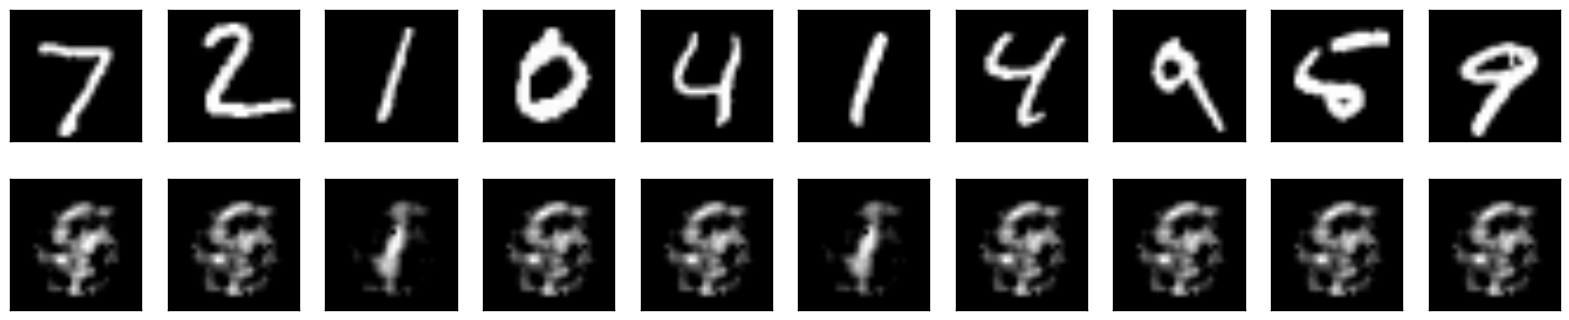

In [17]:
total = 1000
decoded_imgs = []
for i in range(total):
    decoded_imgs.append(sae.predict(X_test[i].reshape(1,-1)))
    
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
# reconstruct error
error = np.zeros(total)
for i in range(total-1):
    error[i] = (np.sum((X_test[i]-decoded_imgs[i])**2)/nb_input)
sorted_error = np.sort(error)
small_thres = sorted_error[10]
large_thres = sorted_error[total-10]

normal_idx = np.where(error <= small_thres)
abnormal_idx = np.where(error >= large_thres)

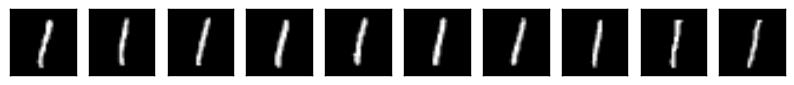

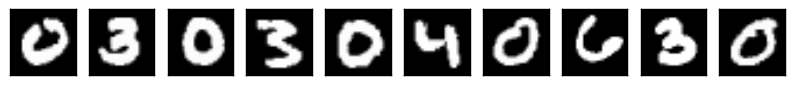

In [19]:
def plot_1_by_10_images(images, figsize=None):
    plt.figure(figsize=(10,4))
    for i in range(10):
        ax = plt.subplot(1,10, i+1)
        plt.imshow(images[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
# show top 10 normal
plot_1_by_10_images(X_test[normal_idx[0][0:10]])

# show top 10 abnormal
plot_1_by_10_images(X_test[abnormal_idx[0][0:10]])
   

In [20]:
# Plot the top 10 least reconstruction error and 
#    top 10 largest reconstruction error for digit
def plot_top_normal_abnormal(digit):
    err_digit = []
    err_idx = []
    for i in range(total - 1):
        if labels_test[i] == digit:
            err_digit.append(error[i])
            err_idx.append(i)
            
    sorted_error = np.sort(err_digit)
    small_thres = sorted_error[10]
    large_thres = sorted_error[len(err_digit) - 10]
    
    normal_idx = np.where(err_digit <= small_thres)
    abnormal_idx = np.where(err_digit >= large_thres)
    good = []
    for i in range(10):
        good.append(X_test[err_idx[normal_idx[0][i]]])
    plot_1_by_10_images(good)
    
    bad = []
    for i in range(10):
        bad.append(X_test[err_idx[abnormal_idx[0][i]]])
    plot_1_by_10_images(bad)


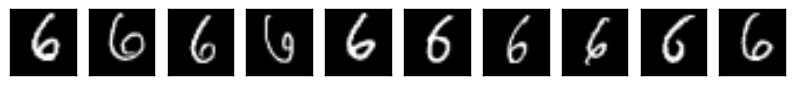

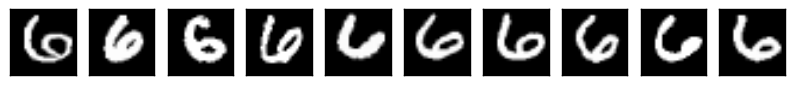

In [21]:
plot_top_normal_abnormal(6)

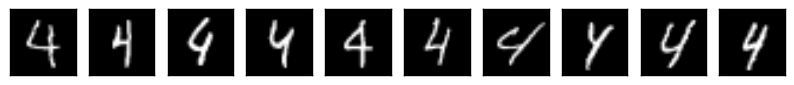

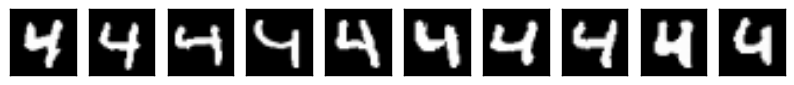

In [22]:
plot_top_normal_abnormal(4)

In [23]:
correct = 0
prediction = np.zeros(total)

for i in range(total):
    softmax = sae.encoder.predict(X_test[i].reshape(1,-1))[0]
    digit = np.where(softmax == np.max(softmax))[0][0]
    prediction[i] = digit
    if digit == labels_test[i]:
        correct = correct + 1
print(correct/total)

0.97


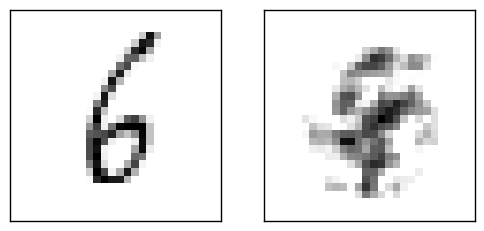

predict: 6.0 	actual: 6


In [24]:
def plot_1_by_2_images(image, reconstruction, figsize=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 2, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    ax = fig.add_subplot(1, 2, 2)
    ax.matshow(reconstruction, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
    
def draw_sae_prediction(j):
    X_plot = X_test[j:j+1]
    reconstruction = sae.predict(X_plot)
    plot_1_by_2_images(to_images(X_plot)[0], to_images(reconstruction)[0])
    print('predict:', prediction[j], '\tactual:', labels_test[j])
    
interact(draw_sae_prediction, j=(0, total-1))
None